In [1]:
import pandas as pd
import numpy as np
import pickle
from surprise import Reader, Dataset, SVD
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import resample
from collections import defaultdict
from math import log2

In [2]:
def load_data():
    reviews = pd.read_pickle("../Pickle/reviews.pkl")
    interactions = pd.read_pickle("../Pickle/interactions.pkl")
    read = pd.read_pickle("../Pickle/read.pkl")
    return reviews, interactions, read

In [3]:
def preprocess_data(df):
    users_with_only_zeros = df.groupby('user_id')['rating'].apply(lambda x: (x == 0).all())
    users_with_only_zeros = users_with_only_zeros[users_with_only_zeros].index
    df = df[~df['user_id'].isin(users_with_only_zeros)]
    
    rated_books = df[df['is_read'] != 0].reset_index(drop = True)
    rated_books = rated_books[rated_books['rating'] != 0].reset_index(drop=True)
    return rated_books

In [4]:
def split_data(df):
    user_counts = df['user_id'].value_counts()
    book_counts = df['book_id'].value_counts()
    
    single_interactions = df[df['user_id'].isin(user_counts[user_counts == 1].index) |
                             df['book_id'].isin(book_counts[book_counts == 1].index)]
    remaining_interactions = df[~df.index.isin(single_interactions.index)]
    
    train_df, test_df = train_test_split(remaining_interactions, test_size=0.2, random_state=42, stratify=remaining_interactions['rating'])
    train_df = pd.concat([train_df, single_interactions], ignore_index=True)
    
    return train_df, test_df

In [5]:
def upsample_ratings(train_df):
    rating_counts = train_df['rating'].value_counts()

# Find the majority class size (highest count)
    majority_count = rating_counts.max()

    MAX_TARGET_SIZE = int(1 * majority_count)

    modified_dfs = []

# Perform upsampling with slight noise addition for each class
    for rating, count in rating_counts.items():
        class_df = train_df[train_df['rating'] == rating]

        if count >= MAX_TARGET_SIZE:
            balanced_df = class_df.copy()
        else:
            balanced_df = resample(class_df,
                               replace=True,
                               n_samples=MAX_TARGET_SIZE,
                               random_state=42)

        # Add random noise to the ratings
            balanced_df['rating'] = balanced_df['rating'] + np.random.uniform(-0.1, 0.1, size=balanced_df.shape[0])
            # Ensure ratings are within the valid range (e.g., between 1 and 5)
            balanced_df['rating'] = balanced_df['rating'].clip(1, 5)

        modified_dfs.append(balanced_df)


    balanced_train = pd.concat(modified_dfs, ignore_index=True)

# Shuffle dataset
    train_df = balanced_train.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return pd.concat([train_df] + modified_dfs, ignore_index=True)

In [6]:
def normalize_ratings(train_df, test_df):
    min_rating = train_df['rating'].min()
    
    train_df = train_df.copy()
    test_df = test_df.copy()
    
    train_df['rating'] = np.log1p(train_df['rating'] - min_rating)
    test_df['rating'] = np.log1p(test_df['rating'] - min_rating)
    
    return train_df, test_df, min_rating

def denormalize_rating(log_scaled_ratings, min_rating):
    original_ratings = np.expm1(np.asarray(log_scaled_ratings, dtype=float))
    return np.clip(original_ratings + min_rating, 1, 5) 


In [7]:
reviews, interactions, read = load_data()

In [8]:
users_with_only_zeros = read.groupby('user_id')['rating'].apply(lambda x: (x == 0).all())
users_with_only_zeros = users_with_only_zeros[users_with_only_zeros].index
read = read[~read['user_id'].isin(users_with_only_zeros)]

In [9]:
# Filter the dataframe to include only rows where 'is_read' is 1
read_df = read[read['is_read'] == 1].reset_index(drop=True)
# Filter the dataframe to include only rows where 'rating' is 0
zero_rating_df = read_df[read_df['rating'] == 0].reset_index(drop=True)
# Filter the reviews dataframe to include only rows where 'rating' is 0
zero_rating_reviews = reviews[reviews['rating'] == 0]
# Filter the interactions dataframe to include only rows where 'rating' is 0
zero_rating_interactions = interactions[interactions['rating'] == 0]
# Get unique user IDs from the zero-rated reviews
zero_rating_review_users = zero_rating_reviews['user_id'].unique()
# Get unique user IDs from the zero-rated interactions
zero_rating_interaction_users = zero_rating_interactions['user_id'].unique()
# Combine the zero-rated reviews and interactions into a single dataframe used for inference
inference = pd.concat([zero_rating_reviews, zero_rating_interactions], ignore_index=True)
# Create a set to store unique user IDs
unique_users = set()
# Combine the unique user IDs from both reviews and interactions, ensuring no duplicates
unique_user_ids = [user_id for user_id in list(zero_rating_review_users) + list(zero_rating_interaction_users) 
                   if user_id not in unique_users and not unique_users.add(user_id)]
# Filter the original dataframe to include only rows with user IDs from the combined list
filtered_df = read_df[read_df['user_id'].isin(unique_user_ids)]
# Filter the original dataframe to include only rows where 'rating' is not 0
non_zero_rating_df = read_df[read_df['rating'] != 0]
# Sample 1% of the non-zero rated rows for more varety in the dataset
non_zero_rating_sample = non_zero_rating_df.sample(frac=0.02, random_state=42)
# Combine the filtered dataframe with the sampled non-zero rated rows
final_df = pd.concat([filtered_df, non_zero_rating_sample], ignore_index=True)
# Reset the index of the final dataframe
df = final_df.reset_index(drop=True)

In [10]:
len(df)

4226857

In [11]:
df['user_id'].nunique()

506501

In [12]:
df = df.astype(np.int32)
df = preprocess_data(df)
train_df, test_df = split_data(df)
train_df = upsample_ratings(train_df)
train_df, test_df, min_rating = normalize_ratings(train_df, test_df)

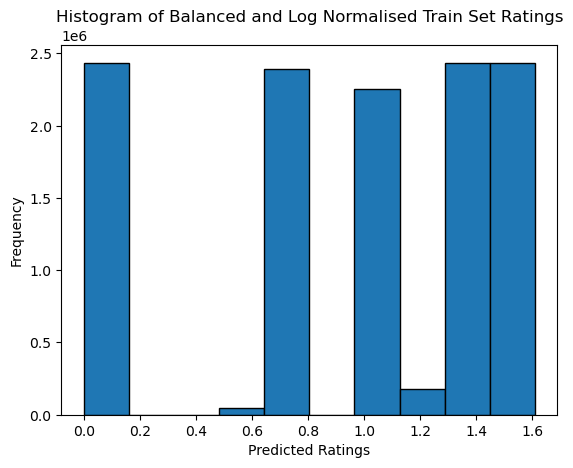

In [13]:
plt.hist(train_df['rating'], bins=10, edgecolor='black')
plt.title('Histogram of Balanced and Log Normalised Train Set Ratings')
plt.xlabel('Predicted Ratings')
plt.ylabel('Frequency')
plt.show()

In [14]:
reader = Reader(rating_scale=(1, 5))
train_data = Dataset.load_from_df(train_df[['user_id', 'book_id', 'rating']], reader)

In [ ]:
param_grid = {
    'n_factors': [100, 200, 300],
    'n_epochs': [20, 40, 60],
    'lr_all': [0.001, 0.1],
    'reg_all': [0.001, 0.1],

}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=2, n_jobs=-1)

gs.fit(train_data)

best_params = gs.best_params['rmse']  
best_model = gs.best_estimator['rmse']  

print(f"Best RMSE: {gs.best_score['rmse']:.4f}")
print(f"Best Parameters: {best_params}")

Best RMSE: 0.4870
Best Parameters: {'n_factors': 300, 'n_epochs': 60, 'lr_all': 0.001, 'reg_all': 0.001}


In [16]:
trainset = train_data.build_full_trainset()

In [17]:
from surprise import accuracy

best_model = SVD(**best_params, verbose=True)
best_model.fit(trainset)

testset = [tuple(x) for x in test_df[['user_id', 'book_id', 'rating']].values]
predictions = best_model.test(testset)

test_rmse = accuracy.rmse(predictions)
test_mae = accuracy.mae(predictions)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing

In [18]:
predictions = best_model.test(testset)

In [25]:
def evaluate_model(predictions, min_rating, k, threshold, item_popularity, num_users):
    # Denormalize predictions
    denormalized_predictions = [
        (uid, iid, true_r * (5 - min_rating) + min_rating, est * (5 - min_rating) + min_rating, details)
        for (uid, iid, true_r, est, details) in predictions
    ]

    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in denormalized_predictions:
        user_est_true[uid].append((iid, est, true_r))

    precisions = []
    recalls = []
    ndcgs = []
    map_scores = []
    mrr_scores = []  # Add MRR scores
    novelty_scores = []
    hit_rate_scores = []
    all_recommended_items = set()  # For catalog coverage
    recommended_relevant_items = set()  # For relevant item coverage

    relevant_items = set(iid for _, iid, true_r, _, _ in denormalized_predictions if true_r >= threshold)

    for user_id, user_ratings in user_est_true.items():
        # Sort predictions by estimated value
        user_ratings_sorted = sorted(user_ratings, key=lambda x: x[1], reverse=True)
        top_k = user_ratings_sorted[:k]

        top_k_items = [iid for iid, _, _ in top_k]
        all_recommended_items.update(top_k_items)

        # Precision and Recall
        n_rel = sum((true_r >= threshold) for (_, _, true_r) in user_ratings)
        n_rec_k = sum((true_r >= threshold) for (_, _, true_r) in top_k)
        n_rel_and_rec_k = sum((true_r >= threshold) for (_, _, true_r) in top_k)

        precision = n_rel_and_rec_k / k if k != 0 else 0
        recall = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        precisions.append(precision)
        recalls.append(recall)

        # NDCG@k
        dcg = sum(
            (true_r >= threshold) / np.log2(idx + 2)
            for idx, (_, _, true_r) in enumerate(top_k)
        )
        idcg = sum(
            1.0 / np.log2(idx + 2) for idx in range(min(n_rel, k))
        )
        ndcg = dcg / idcg if idcg != 0 else 0
        ndcgs.append(ndcg)

        # MAP@k
        hits = 0
        sum_precisions = 0
        for idx, (_, _, true_r) in enumerate(top_k):
            if true_r >= threshold:
                hits += 1
                sum_precisions += hits / (idx + 1)
        ap = sum_precisions / min(n_rel, k) if n_rel != 0 else 0
        map_scores.append(ap)

        # MRR Calculation: Find the reciprocal of the rank of the first relevant item
        first_relevant_rank = None
        for idx, (_, _, true_r) in enumerate(top_k):
            if true_r >= threshold:
                first_relevant_rank = idx + 1  # Rank is 1-based
                break

        if first_relevant_rank is not None:
            mrr_scores.append(1 / first_relevant_rank)
        else:
            mrr_scores.append(0)

        # Novelty (1 - average popularity of the recommended items)
        novelty = np.mean([1 - (item_popularity.get(iid, 1) / num_users) for iid in top_k_items])
        novelty_scores.append(novelty)

        # Hit Rate (proportion of users who have at least one relevant item in top_k)
        hit_rate = 1 if n_rel_and_rec_k > 0 else 0
        hit_rate_scores.append(hit_rate)

        # For Relevant Item Coverage@k
        recommended_relevant_items.update([iid for iid, est, true_r in top_k if true_r >= threshold])

    # Catalog Coverage@k
    catalog_coverage = len(all_recommended_items) / len(item_popularity) if item_popularity else 0

    # User Coverage@k (the proportion of users with at least one relevant recommendation)
    user_coverage = sum(1 for user_ratings in user_est_true.values() if any(true_r >= threshold for _, _, true_r in user_ratings)) / len(user_est_true)

    # Return results
    return (
        np.mean(precisions),
        np.mean(recalls),
        np.mean(ndcgs),
        np.mean(map_scores),
        np.mean(mrr_scores),  # Include MRR here
        np.mean(novelty_scores),
        np.mean(hit_rate_scores),
        user_coverage
    )


k = 5
threshold = 4  # Relevance threshold
item_popularity = test_df['book_id'].value_counts().to_dict()
num_users = test_df['user_id'].nunique()

# Compute metrics
precision, recall, ndcg, map_score, mrr, novelty, hit_rate, user_coverage = evaluate_model(
    predictions, min_rating=1.0, k=k, threshold=threshold, item_popularity=item_popularity, num_users=num_users
)

# Print results
print(f'Precision@{k}: {precision:.4f}')
print(f'Recall@{k}: {recall:.4f}')
print(f'nDCG@{k}: {ndcg:.4f}')
print(f'MAP@{k}: {map_score:.4f}')
print(f'MRR@{k}: {mrr:.4f}')
print(f'Novelty: {novelty:.4f}')
print(f'Hit Rate: {hit_rate:.4f}')
print(f'User Coverage: {user_coverage:.4f}')


Precision@5: 0.3389
Recall@5: 0.9250
nDCG@5: 0.9438
MAP@5: 0.9383
MRR@5: 0.9426
Novelty: 0.9995
Hit Rate: 0.9560
User Coverage: 0.9560


In [20]:
import pickle
with open("../Pickle/best_svd_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

with open("../Pickle/best_svd_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

In [21]:
# trainset = loaded_model.trainset

def predict_with_fallback(user_id, book_id):
    if not trainset.knows_user(user_id):
        return np.nan  # User not in training
    if not trainset.knows_item(book_id):
        return np.nan  # Book not in training
    
    pred = loaded_model.predict(user_id, book_id)
    return pred.est  # Return estimated rating

inference["predicted_rating"] = inference.apply(
    lambda row: predict_with_fallback(row["user_id"], row["book_id"]), axis=1
)

In [22]:
inference.loc[inference["predicted_rating"].notna(), "predicted_rating"] = inference["predicted_rating"].apply(
    lambda x: denormalize_rating(x, min_rating) if pd.notna(x) else x)

In [23]:
inference = inference.dropna(subset=['predicted_rating'])
inference = inference.reset_index(drop = True)
inference = inference[['user_id', 'book_id', 'predicted_rating']]
inference = inference.rename(columns={"predicted_rating": "rating"})
inference['rating'] = inference['rating'].apply(lambda x: round(x, 0))

In [24]:
with open('../Pickle/imputed_ratings.pkl', 'wb') as f:
    pickle.dump(inference, f)